# Viva la Factory

Factory is way to train several different classifiers on the same dataset and compare the quailty of predictions.

### First, enable plotting

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Loading data

### download particle identification Data Set from UCI

In [2]:
!cd toy_datasets; wget -O MiniBooNE_PID.txt -nc MiniBooNE_PID.txt https://archive.ics.uci.edu/ml/machine-learning-databases/00199/MiniBooNE_PID.txt

File `MiniBooNE_PID.txt' already there; not retrieving.


In [3]:
import numpy, pandas
from rep.utils import train_test_split

In [4]:
import numpy, pandas
from rep.utils import train_test_split
from sklearn.metrics import roc_auc_score

data = pandas.read_csv('toy_datasets/MiniBooNE_PID.txt', sep='\s*', skiprows=[0], header=None, engine='python')
labels = pandas.read_csv('toy_datasets/MiniBooNE_PID.txt', sep=' ', nrows=1, header=None)
labels = [1] * labels[1].values[0] + [0] * labels[2].values[0]
data.columns = ['feature_{}'.format(key) for key in data.columns]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.5)

## Variables needed for analysis

In [5]:
train_variables = ["feature_new01: feature_0/feature_1", "feature_2", "feature_26", "feature_12", "feature_24",
                   "feature_25", "feature_16",]
plot_variables = train_variables + ['feature_3']

# Factory of different models

This class is OrderedDict, with additional interface, main methods are:

* `factory.add_classifier(name, classifier)` 

* `factory.fit(X, y, sample_weight=None, ipc_profile=None, features=None)` <br />
    train all classifiers in factory<br />
    if `features` is not None, then all classifiers will be trained on these features <br />
    you can pass the name of ipython cluster via `ipc_profile` for parallel training
    
* `factory.test_on_lds(lds)` - test all models on lds(`rep.data.storage.LabeledDataStorage`)  <br />
    returns report (`rep.report.classification.ClassificationReport`)

In [6]:
from rep.metaml import ClassifiersFactory
from rep.estimators import TMVAClassifier, SklearnClassifier, XGBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

## Define classifiers (that will be compared)
Please pay attention that we set very small number of trees, just to make this notebook work fast. 
Don't forget to tune classifier!



In [7]:
factory = ClassifiersFactory()
# There are different ways to add classifiers to Factory:
factory.add_classifier('tmva', TMVAClassifier(NTrees=50, features=train_variables, Shrinkage=0.05))
factory.add_classifier('ada', AdaBoostClassifier(n_estimators=10))
factory['xgb'] = XGBoostClassifier(features=train_variables)

### Create a copy of the factory with all classifiers

In [8]:
from copy import deepcopy
factory_copy = deepcopy(factory)

## Training
__pay attention:__ <br />
for the first factory we pointed features that will be used in training and all classifiers will use them, <br />
for the second factory all the classifiers will use those features we set in their constuctors

In [9]:
%time factory.fit(train_data, train_labels, features=train_variables)
pass

Overwriting features of estimator tmva
Overwriting features of estimator xgb
model tmva         was trained in 10.97 seconds
model ada          was trained in 0.84 seconds
model xgb          was trained in 16.61 seconds
Totally spent 28.42 seconds on training
CPU times: user 18 s, sys: 167 ms, total: 18.2 s
Wall time: 28.4 s


/Users/antares/code/xgboost/wrapper/xgboost.py:80: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if label != None:
/Users/antares/code/xgboost/wrapper/xgboost.py:82: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if weight !=None:


In [10]:
factory.predict_proba(train_data)

data was predicted by tmva         in 5.17 seconds
data was predicted by ada          in 0.08 seconds
data was predicted by xgb          in 1.08 seconds
Totally spent 6.33 seconds on prediction


OrderedDict([('tmva', array([[ 0.43239744,  0.56760256],
       [ 0.33045031,  0.66954969],
       [ 0.46480532,  0.53519468],
       ..., 
       [ 0.22967905,  0.77032095],
       [ 0.8663442 ,  0.1336558 ],
       [ 0.58605435,  0.41394565]])), ('ada', array([[ 0.50221124,  0.49778876],
       [ 0.48490343,  0.51509657],
       [ 0.48080564,  0.51919436],
       ..., 
       [ 0.47430966,  0.52569034],
       [ 0.60044157,  0.39955843],
       [ 0.5544215 ,  0.4455785 ]])), ('xgb', array([[ 0.22535729,  0.77464271],
       [ 0.12695003,  0.87304997],
       [ 0.73083204,  0.26916793],
       ..., 
       [ 0.66761619,  0.33238381],
       [ 0.99849308,  0.00150696],
       [ 0.92347258,  0.07652737]], dtype=float32))])

In [11]:
%time factory_copy.fit(train_data, train_labels)
pass

model tmva         was trained in 8.88 seconds
model ada          was trained in 5.26 seconds
model xgb          was trained in 21.76 seconds
Totally spent 35.90 seconds on training
CPU times: user 26.5 s, sys: 229 ms, total: 26.8 s
Wall time: 35.9 s


# Everybody loves plots!
## Visualizing of training result with factory

`ClassificationReport` class provides the posibility to get classification description to compare different models. <br />Below you can find available functions which can help you to analyze result on arbitrary dataset.

There are different plotting backends supported:
* __matplotlib__ (default, de-facto standard plotting library, mpld3 allows turning this into interactive plots), 
* __plotly__ (proprietary package with interactive plots, information is kept on the server), 
* __ROOT__ (the library used by CERN people),
* __bokeh__ (open-source package with interactive plots) 

### Get ClassificationReport object
report has many useful methods

In [12]:
report = factory.test_on(test_data, test_labels)

## Plot importances of features
Only the features used in training are compared

Estimator tmva doesn't support feature importances


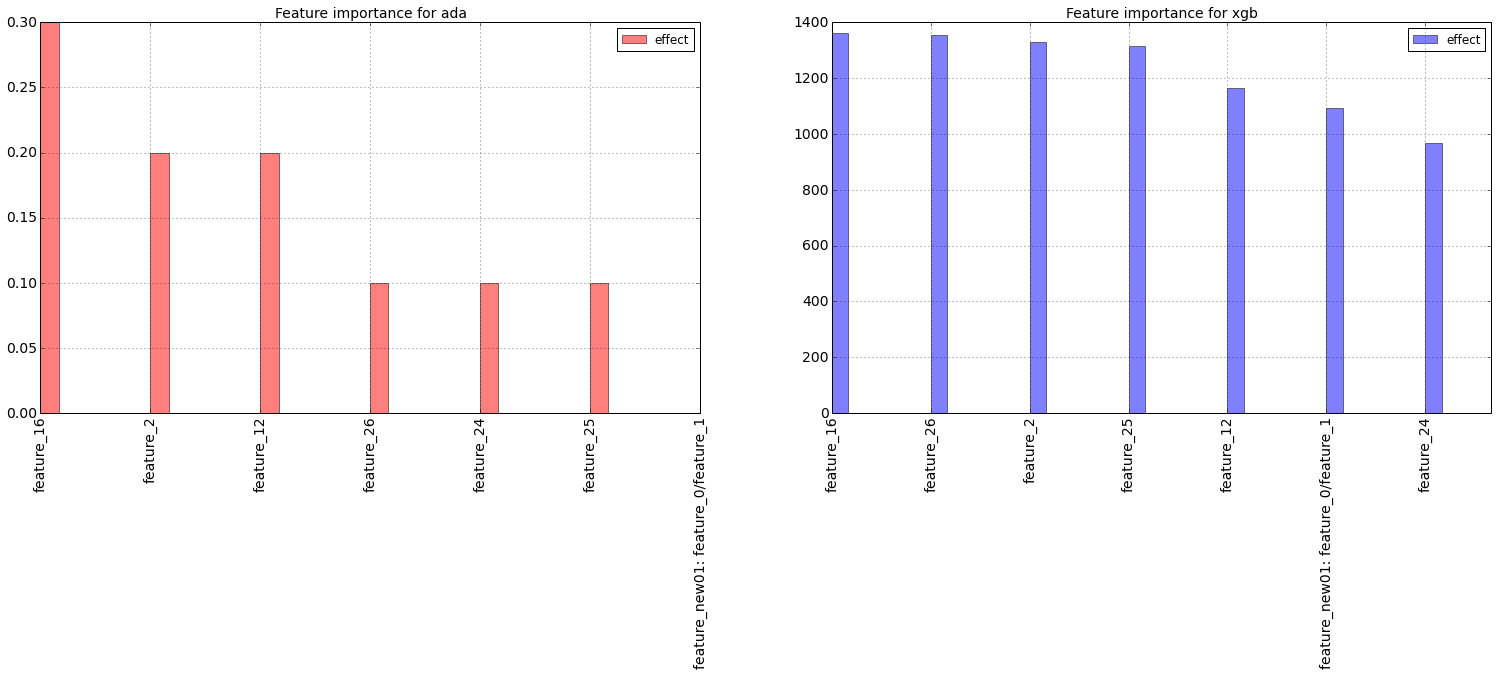

In [13]:
features_importances = report.feature_importance()
features_importances.plot()

## Now  `feature_importances` is object that can be plotted 
not only in matplotlib, but in other libraries too. For instance, with plotly

In [14]:
features_importances.plot_plotly('importances', figsize=(15, 6))

## Plot learning curves to see possible overfitting of trained classifier
Learning curves are powerful and simple tool to analyze the behaviour of your model.

In [15]:
from rep.report.metrics import RocAuc

Estimator tmva doesn't support stage predictions


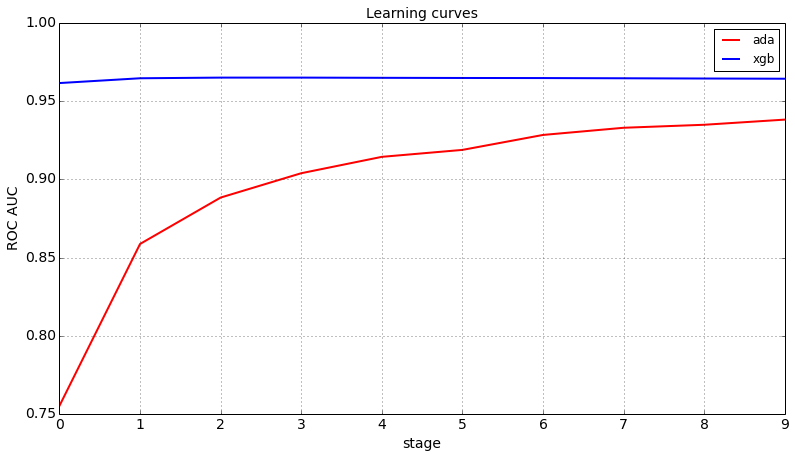

In [16]:
learning_curve = report.learning_curve(RocAuc(), metric_label='ROC AUC', steps=1)
learning_curve.plot(new_plot=True)

In [17]:
# plotting the same curve (without recomputing) using different plotting library
learning_curve.plot_plotly(plotly_filename='learning curves', figsize=(18, 8))

## Plot correlation between features

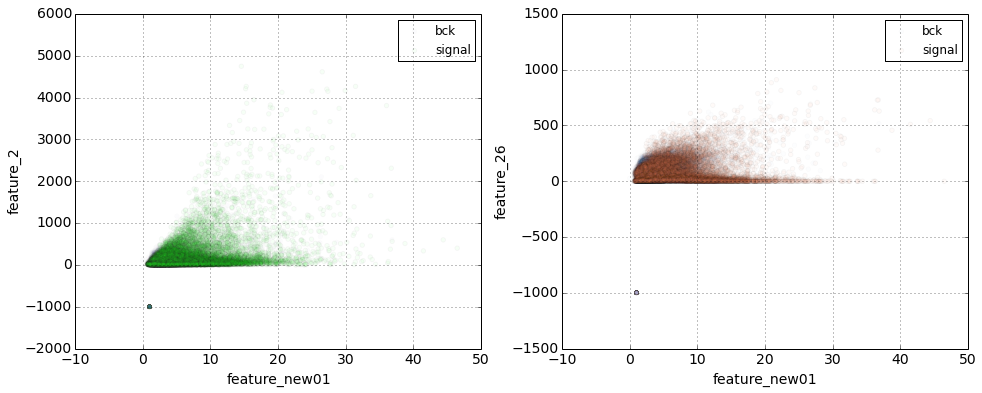

In [18]:
correlation_pairs = []
correlation_pairs.append((plot_variables[0], plot_variables[1]))
correlation_pairs.append((plot_variables[0], plot_variables[2]))

report.scatter(correlation_pairs, alpha=0.01).plot()

## Plot data information: features correlation matrix

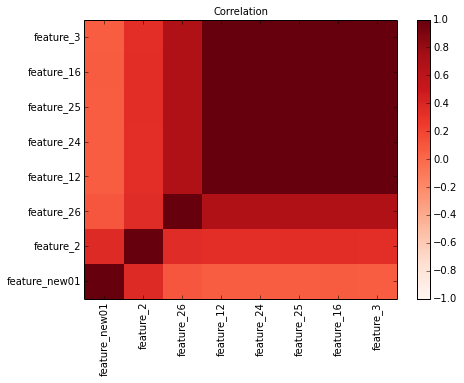

In [19]:
# plot correlations between variables for signal-like and bck-like events
report.features_correlation_matrix(features=plot_variables).plot(new_plot=True, show_legend=False, figsize=(7, 5))

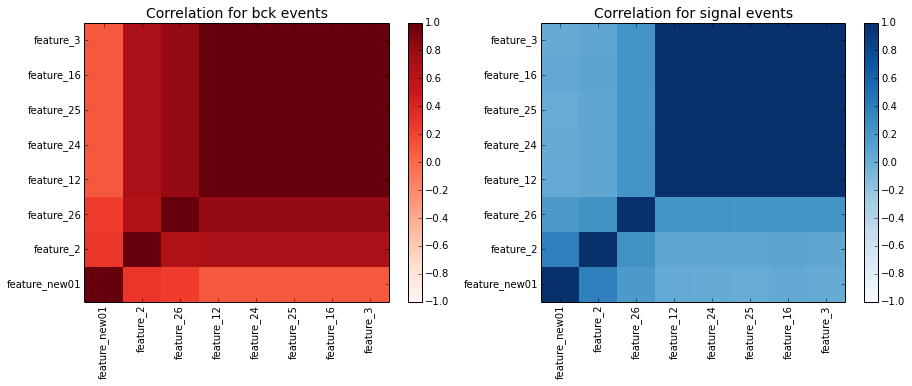

In [20]:
report.features_correlation_matrix_by_class(features=plot_variables).plot(new_plot=True, show_legend=False, figsize=(15, 5))

In [21]:
# plot correlations between variables just for bck-like events
corr = report.features_correlation_matrix_by_class(features=plot_variables[:4], labels_dict={0: 'background'}, grid_columns=1)
corr.plot_plotly(plotly_filename='correlations', show_legend=False, fontsize=8, figsize=(8, 6))

## Plot distribution for each feature

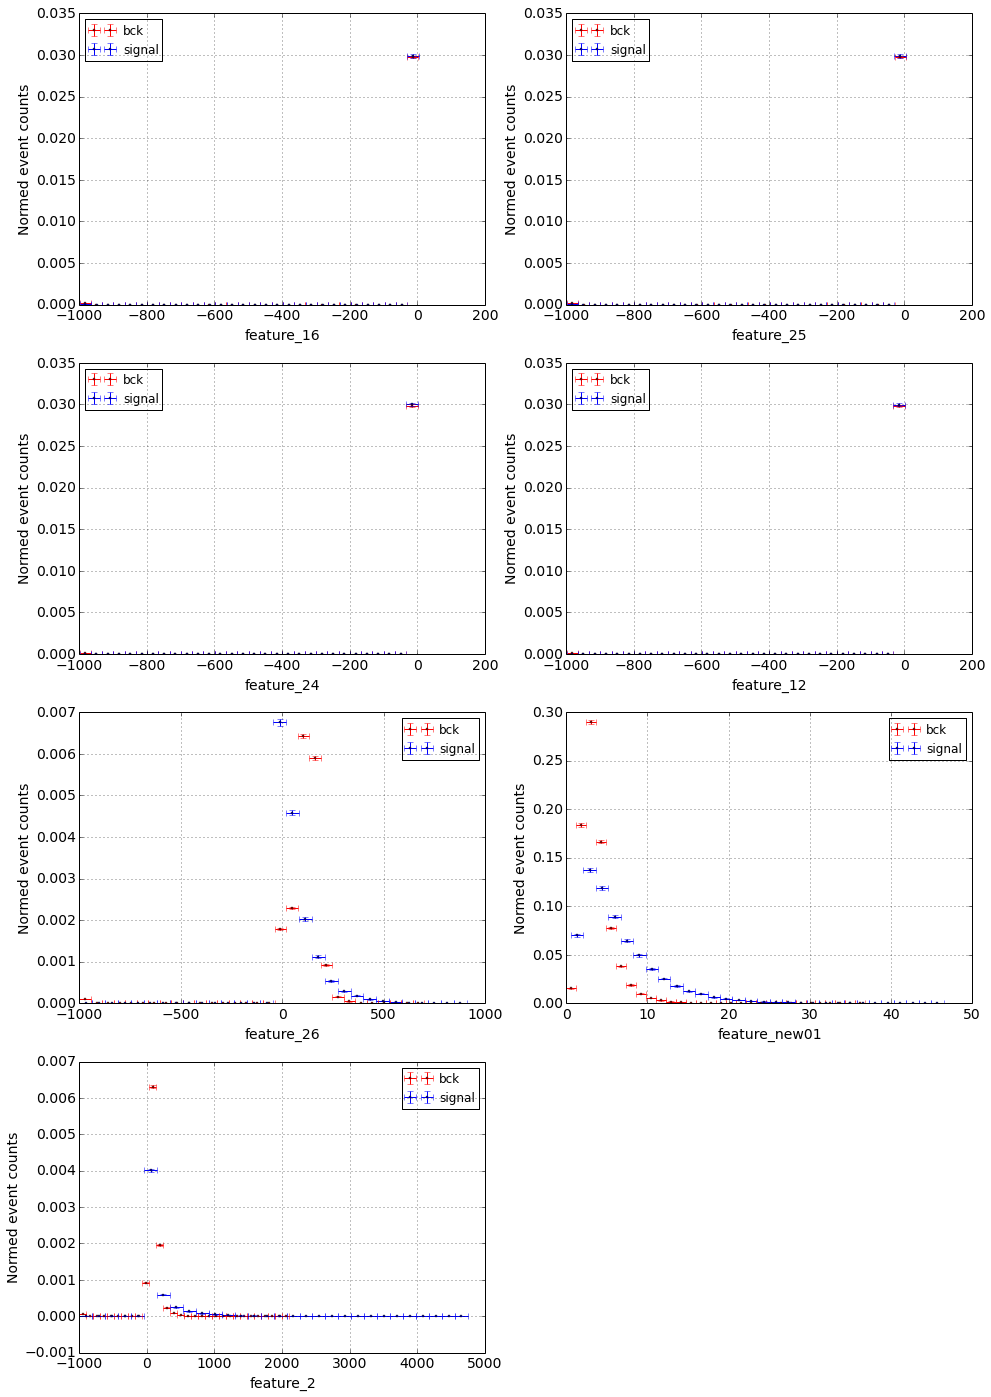

In [22]:
# use just common features for all classifiers
report.features_pdf().plot()

In [23]:
# use all features in data
report.features_pdf(data.columns).plot_plotly('distributions')

## Plot predictions distributions

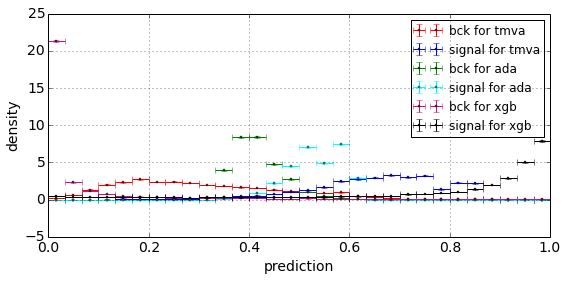

In [24]:
report.prediction_pdf().plot(new_plot=True, figsize = (9, 4))

In [25]:
report.prediction_pdf(labels_dict={0: 'background'}, size=5).plot_plotly('models pdf')

## ROC curves (receiver operating characteristic)
Plot roc curve for train, test data (it's the same as BackgroundRejection vs Signal Efficiency plot)

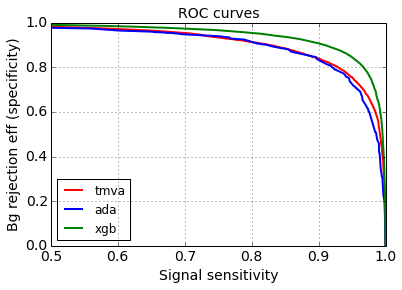

In [26]:
report.roc().plot(xlim=(0.5, 1))

In [27]:
# plot the same distribution using interactive plot
report.roc().plot_plotly(plotly_filename='ROC')

## Plot 'flatness' of classifier prediction
(this is dependence of efficiency on variables of dataset)

In [28]:
efficiencies = report.efficiencies(['feature_3'], ignored_sideband=0.01)
efficiencies_with_errors = report.efficiencies(['feature_3'], errors=True, bins=15, ignored_sideband=0.01)

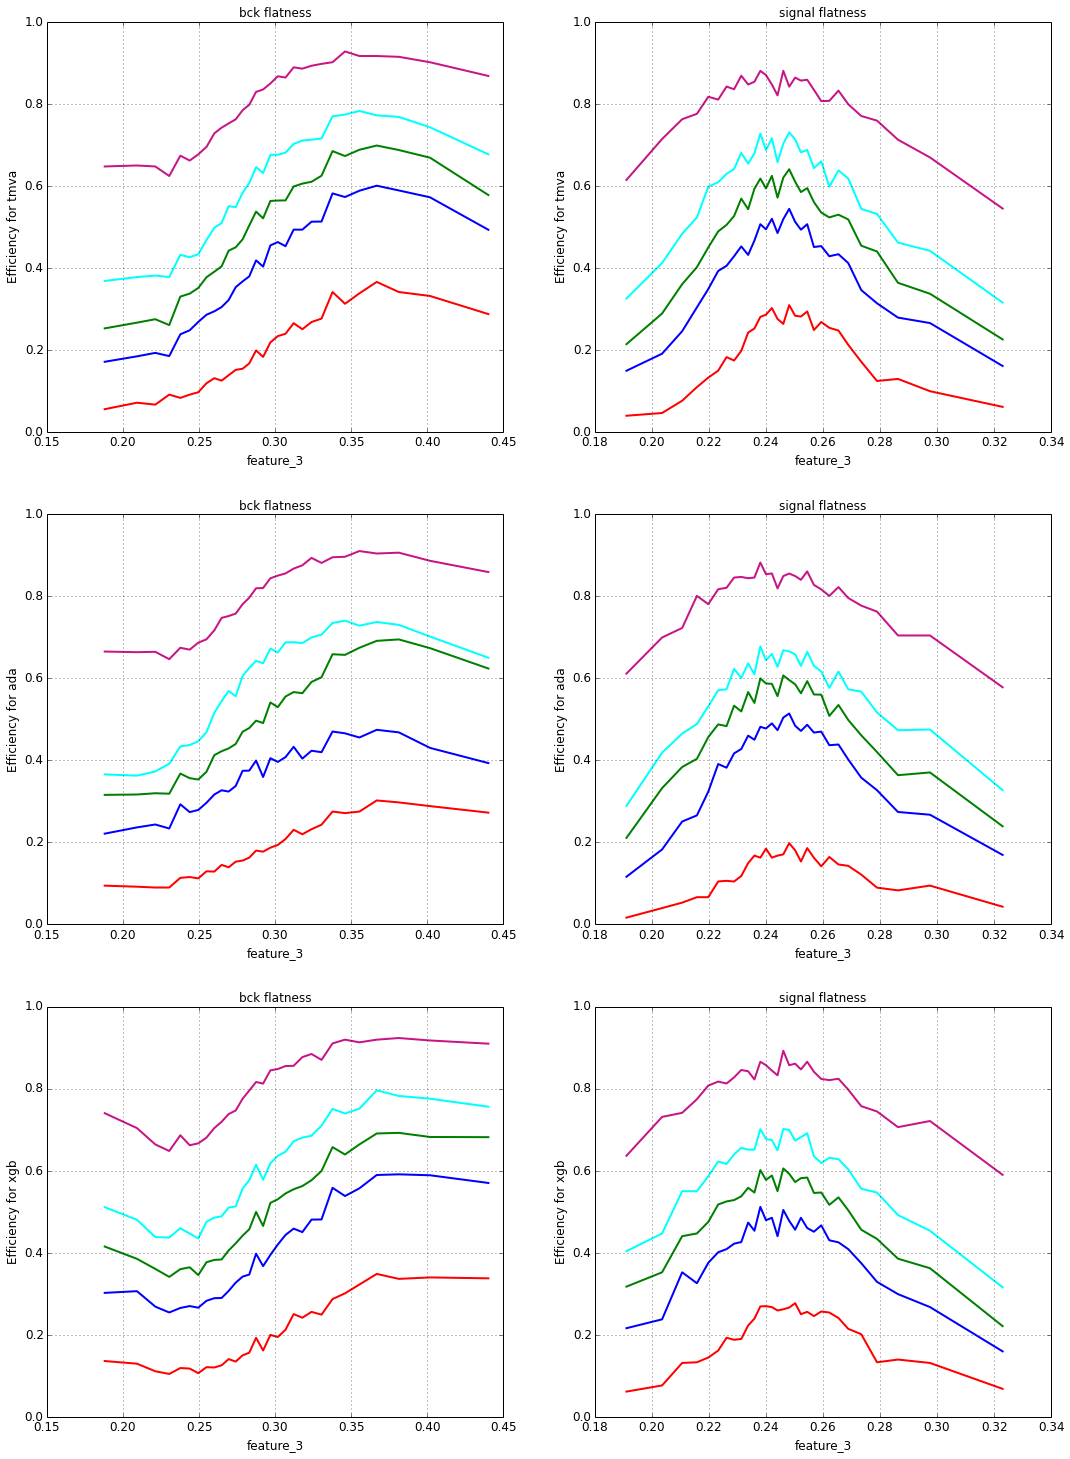

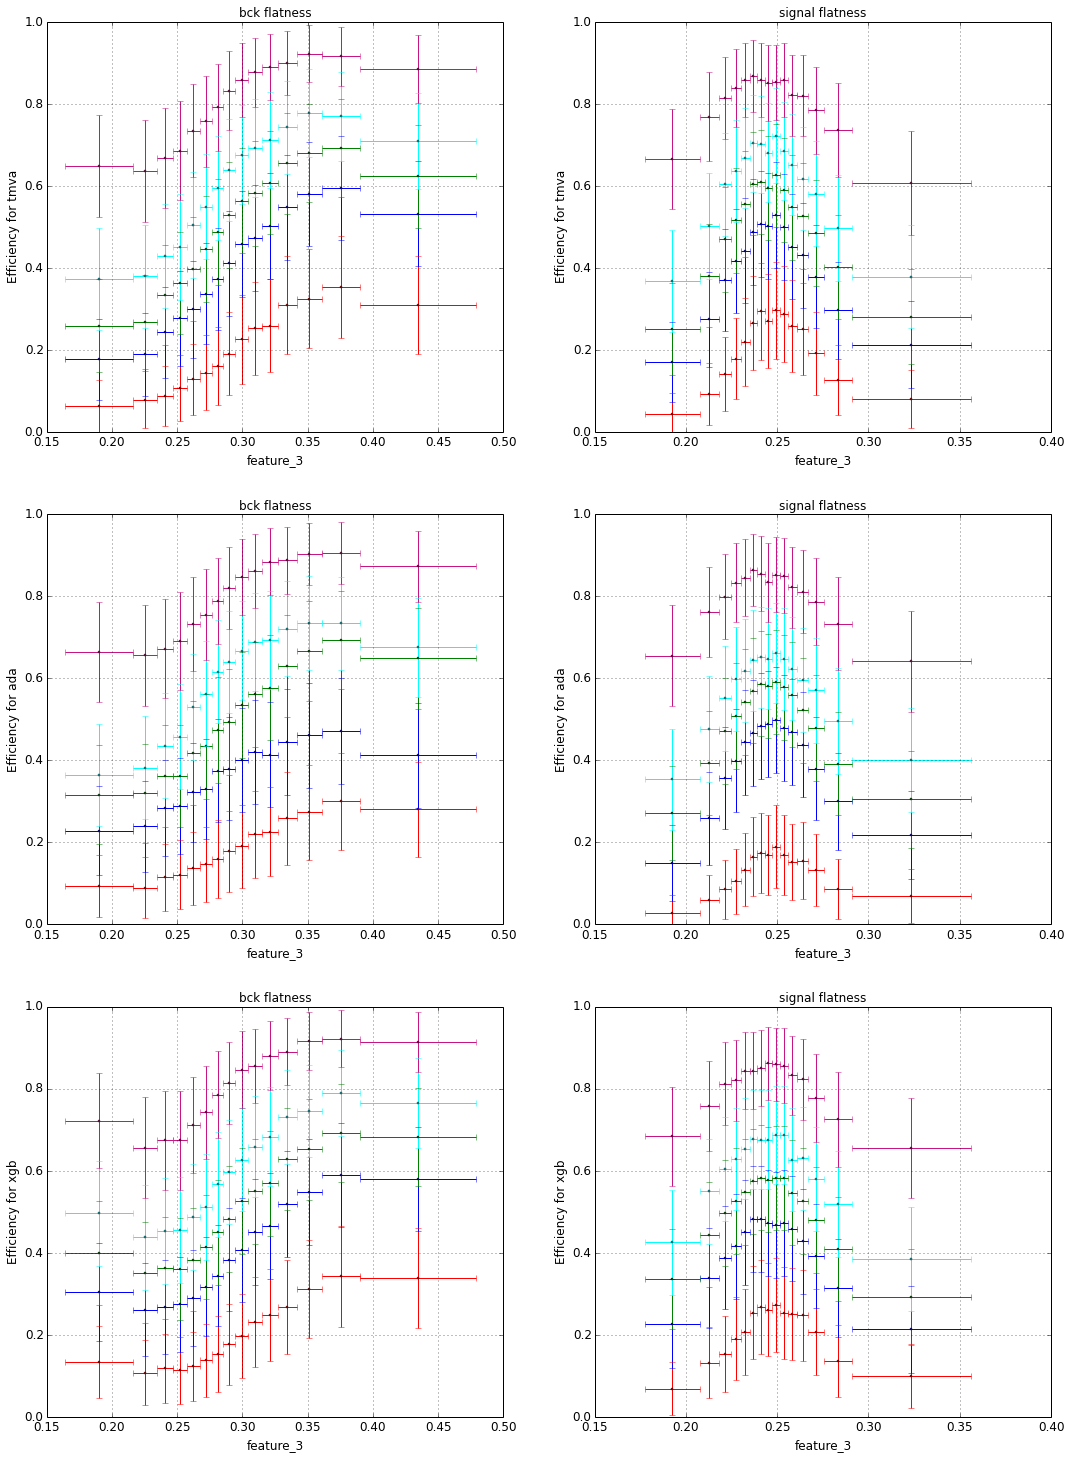

In [29]:
efficiencies.plot(figsize=(18, 25), fontsize=12, show_legend=False)
efficiencies_with_errors.plot(figsize=(18, 25), fontsize=12, show_legend=False)

In [30]:
efficiencies.plot_plotly("efficiencies", show_legend=False, figsize=(18, 20))
efficiencies_with_errors.plot_plotly("efficiencies error", show_legend=False, figsize=(18, 20))

## Quality on different metrics
look how you can estimate the quality with your custom binary metrics and look for optimal threshold

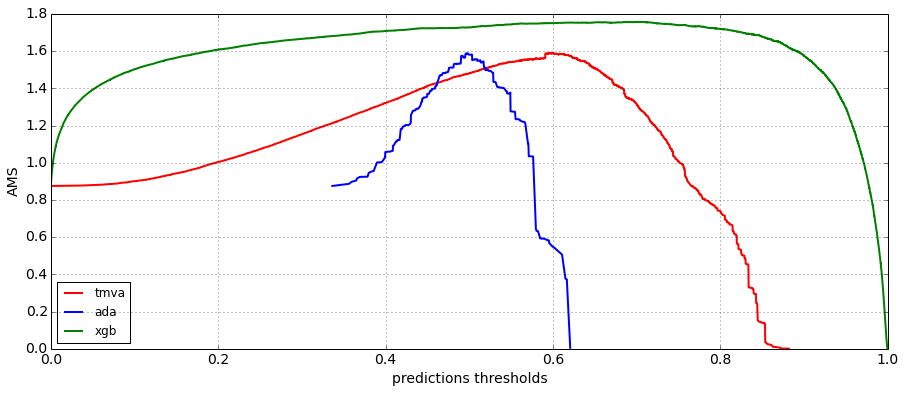

In [31]:
# define metric functions of interest
def AMS(s, b): 
    b_reg = 0.01
    radicand = 2 *( (s+b+b_reg) * numpy.log (1.0 + s/(b+b_reg)) - s)
    return numpy.sqrt(radicand)

def significance(s, b): 
    b_reg = 0.01
    radicand = s / numpy.sqrt(b + b_reg)
    return radicand


metrics = report.metrics_vs_cut(AMS, metric_label='AMS')
metrics.plot(new_plot=True, figsize=(15, 6))

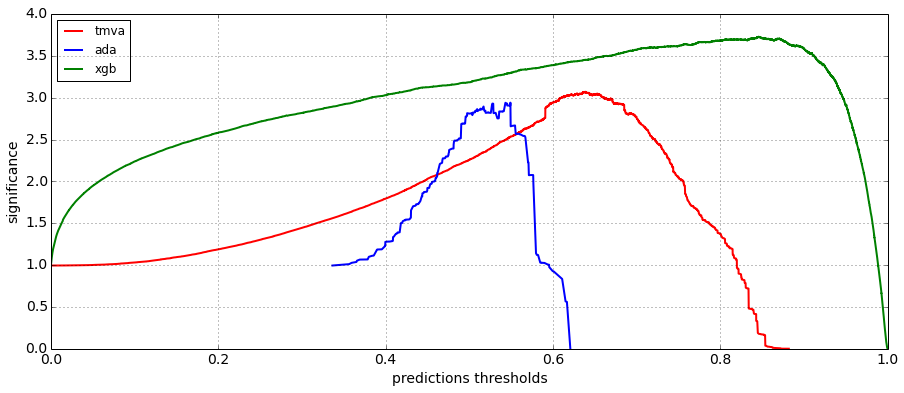

In [32]:
metrics = report.metrics_vs_cut(significance, metric_label='significance')
metrics.plot(new_plot=True, figsize=(15, 6))

### The same using plotly

In [33]:
metrics.plot_plotly('metrics')

/Users/antares/.virtualenvs/rep_open/lib/python2.7/site-packages/plotly/plotly/plotly.py:186: UserWarning:

Woah there! Look at all those points! Due to browser limitations, Plotly has a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Trying using the image API to return an image instead of a graph URL
(2) Use matplotlib
(3) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/Users/antares/.virtualenvs/rep_open/lib/python2.7/site-packages/plotly/plotly/plotly.py:674: UserWarning:

Estimated Draw Time Too Long



The draw time for this plot will be slow for all clients.


# Exercises

__Exercise 1__. Create weight column for test and train datasets. Then do `fit` for factory using this weights columns. Get model information using weights.

__Exercise 2__. Train another classifiers,  plays with parameters and feature sets. 

__Exercise 3__. Try use your cluster (change paths and configurations)